In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from fitting import create_ensemble, get_data, get_datasets

import sys
sys.path.append("../")

folder = ""
save_dir = "alpha_1000_snapshot"
all_k, all_images, bins, xx = get_data(folder)


bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)
ensemble = ensemble
ensemble.cuda();

/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([20, 3, 180, 180])
torch.Size([20, 3])
torch.Size([180])


In [2]:
all_k.shape

torch.Size([20, 3])

In [3]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cuda())[0].unsqueeze(0) for i in range(len
                                                                          (ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        torch.save(model_pred, "/".join([save_dir,"model_pred_images.pt"]))
    else:
        model_pred = torch.load( "/".join([save_dir,"model_pred_images.pt"]))


In [4]:
# compare initial beam distributions
from torch_track import Beam

# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]


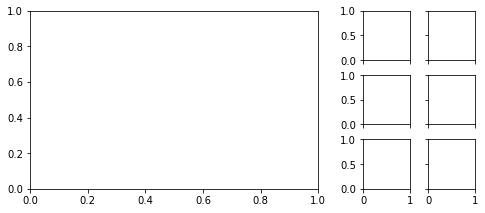

In [39]:
from visualization import add_image, add_projection, add_image_projection
from utils import calc_rms_size
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase


# create gridspec
def create_figure():
    fig = plt.figure()
    fig.set_size_inches(7,3)

    # create subfigures
    subfigs = fig.subfigures(1,2, width_ratios=[5,2],wspace=0.05)
    quad_scan_axis = subfigs[0].subplots(1,gridspec_kw={"right":0.925, "top":0.975, "bottom":0.15})

    proj_axes = subfigs[1].subplots(3,2, sharex="all",sharey="all",gridspec_kw={"hspace":0.3,"wspace":0.4, "top":0.975, "bottom":0.15})
    
    return fig, quad_scan_axis, proj_axes

create_figure();

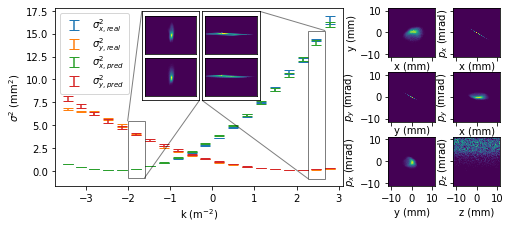

In [40]:
# choose image indexes for comparison
image_idxs = [5,-2]
image_vmax = None
image_bins = bins
image_linewidth = 1

# choose phase spaces to plot
phase_spaces = [["x","y"],["x","px"],["y","py"],["x","py"],["y","px"],["z","pz"]]
phase_space_bins = bins / 1.5

# quad scan
quad_scan_scale = 1e6

# generate plot skeleton
fig, quad_scan_ax, proj_axes = create_figure()

# add quad scan data
means, variances = calc_rms_size(xx, all_images.cpu())
pmeans, pvariances = calc_rms_size(xx, model_pred)


k = all_k[:, 0].cpu()
mean_variance = torch.mean(variances, dim=-2).cpu() * quad_scan_scale
error_variance = torch.std(variances, dim=-2).cpu() * quad_scan_scale

#quad_scan_ax.plot(k, variances.squeeze()[:,0] * quad_scan_scale,".")
#quad_scan_ax.plot(k, variances.squeeze()[:,1] * quad_scan_scale,".")

quad_scan_ax.errorbar(k, mean_variance[...,0], error_variance[...,0],capsize=5,ls='', label="$\sigma^2_{x, real}$")
quad_scan_ax.errorbar(k, mean_variance[...,1], error_variance[...,1],capsize=5,ls='', label="$\sigma^2_{y, real}$")

mean_pvariance = torch.mean(pvariances, dim=-2) * quad_scan_scale
error_pvariance = torch.std(pvariances, dim=-2) * quad_scan_scale

quad_scan_ax.errorbar(k, mean_pvariance[...,0], error_pvariance[...,0],capsize=5,ls='', label="$\sigma^2_{x, pred}$")
quad_scan_ax.errorbar(k, mean_pvariance[...,1], error_pvariance[...,1],capsize=5,ls='', label="$\sigma^2_{y, pred}$")

quad_scan_ax.set_xlabel("k (m$^{-2}$)")
quad_scan_ax.set_ylabel("$\sigma^2$ (mm$^2$)")
quad_scan_ax.legend(loc=2,labelspacing=0.1)

def remove_ticks(ax):
    ax.set_yticks([])
    ax.set_xticks([])
    
# add inset axes for images
indicator_width = 0.4
indicator_buffer = 1.0
inset_height = 0.5
gap = 0.05
image_extent = 10

inset_locs = torch.tensor([0.25, 0.46]) + 0.05

for j, idx in enumerate(image_idxs[:2]):
    center_k = k[idx]

    axins = quad_scan_ax.inset_axes([inset_locs[j],1 - inset_height - 0.02,inset_height*0.4,inset_height])
    quad_scan_ax.indicate_inset(
        [
            center_k - indicator_width/2, 
            torch.min(mean_pvariance[idx]) - indicator_buffer, 
            indicator_width, 
            torch.max(mean_pvariance[idx]) + 2*indicator_buffer + torch.min(mean_pvariance[idx])
        ], 
        inset_ax=axins, edgecolor="black"
    )
    remove_ticks(axins)
    
    top_ax = axins.inset_axes([gap, 0.5+gap/2, 1-2*gap,0.5 - 1.5*gap])
    remove_ticks(top_ax)

    bottom_ax = axins.inset_axes([gap,gap,1-2*gap,0.5 - 1.5*gap])
    remove_ticks(bottom_ax)
    
    top_ax.pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0].cpu(),vmax=image_vmax)
    bottom_ax.pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0].cpu(),vmax=image_vmax)
    
    for ele in [top_ax, bottom_ax]:
        ele.set_ylim(-image_extent, image_extent)
        ele.set_xlim(-image_extent, image_extent)
        ele.collections[0].set_rasterized(True)


# get list of axes for plotting the phase space projections
ph_axes = proj_axes.flatten()

# add phase space projections
for ax, pair in zip(ph_axes, phase_spaces):
    _, pred_image = add_image(ax, *pair, pred_initial_beams, [phase_space_bins]*2,
                              scale_axis=1e3)
    ax.collections[0].set_rasterized(True)
    unit = []
    for i in [0,1]:
        if "p" in pair[i]:
            pair[i] = f"$p_{pair[i][-1]}$"
            unit += ["(mrad)"]
        else:
            unit += ["(mm)"]

    ax.set_xlabel(pair[0] + " " + unit[0])
    ax.set_ylabel(pair[1] + " " + unit[1], labelpad=3)
    
#ph_axes.flatten()[-1].set_ylabel("$\delta$ (10$^{-3}$)");
fig.savefig("exp_results.png", dpi=300)
fig.savefig("exp_results.svg")
    

In [7]:
all_images.shape

torch.Size([20, 3, 180, 180])